## Imports

In [2]:
import numpy as np
import os
os.system("pip install mitsuba")
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

In [3]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=8,
                             num_cols=8,
                             pattern="iso",
                             polarization="V")
# scene.tx_array_f2 = PlanarArray(num_rows=10,
#                              num_cols=10,
#                              pattern="iso",
#                              polarization="V")

scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")


# Define and add a first transmitter to the scene
tx_f1 = Transmitter(name='tx_f1',
                  position=[32, 32, 10],
                  orientation=[0, 0, 0],
                  power_dbm=44)
scene.add(tx_f1)

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=5,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(1, 1),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[128, 128],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


rm.path_gain.shape=(1, 128, 128)
[[[8.55662e-10, 6.98216e-10, 2.87773e-10, .. 122 skipped .., 7.98289e-10, 1.01289e-09, 1.27006e-09],
  [9.92924e-10, 8.25553e-10, 6.72226e-10, .. 122 skipped .., 1.06143e-09, 1.04542e-09, 1.00357e-09],
  [1.13556e-09, 9.59605e-10, 7.96408e-10, .. 122 skipped .., 9.49137e-10, 1.04742e-09, 1.15137e-09],
  .. 122 skipped ..,
  [3.67141e-09, 4.55766e-09, 4.29388e-09, .. 122 skipped .., 8.83518e-11, 1.68714e-10, 2.74717e-10],
  [5.53413e-09, 5.26025e-09, 5.41515e-09, .. 122 skipped .., 9.23182e-11, 1.67633e-10, 2.91758e-10],
  [6.92509e-09, 5.48578e-09, 6.60042e-09, .. 122 skipped .., 7.62271e-11, 1.51535e-10, 2.70924e-10]]]


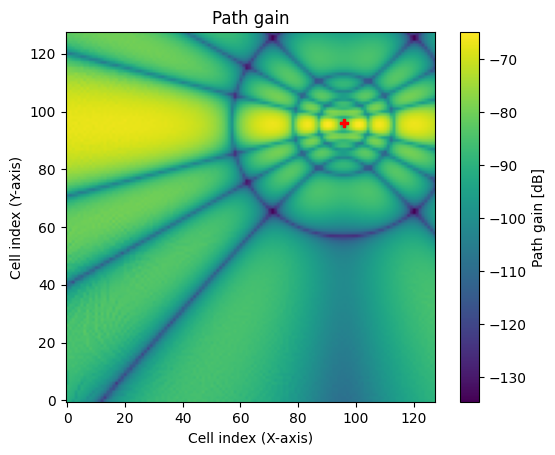

In [4]:
rm.show(metric="path_gain");
print(f'{rm.path_gain.shape=}') # Path gain
print(rm.path_gain)

In [5]:
# Remove transmitters here so that the cell can be executed multiple times
scene.remove("tx1")
scene.remove("tx2")

tx1 = Transmitter(name='tx1',
                  position=[-150, -100, 20],
                  orientation=[np.pi/6, 0, 0],
                  power_dbm=21)
scene.add(tx1)

tx2 = Transmitter(name='tx2',
                  position=np.array([0, 150 * np.tan(np.pi/3) - 100, 20]),
                  orientation=[-np.pi/2, 0, 0],
                  power_dbm=27)
scene.add(tx2)

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

As soon as there are multiple transmitters in a scene, we can either visualize
a metric for specific transmitter or visualize the maximum metric across all
transmitters. The latter option is relevant if we want to inspect, e.g., the SINR across a large
scene, assuming that a receiver always connects to the transmitter providing
the best SINR.

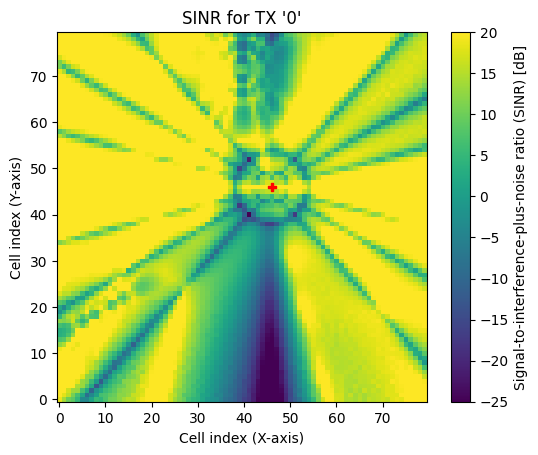

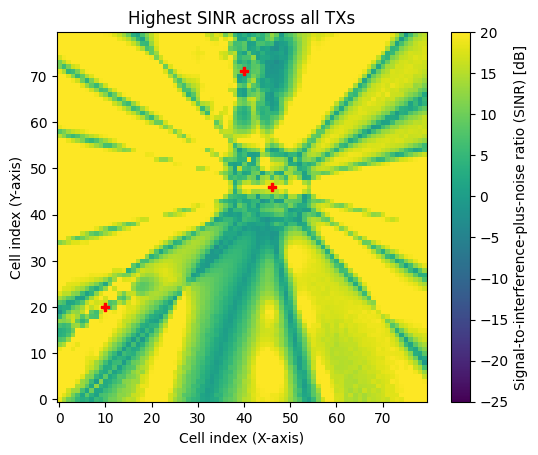

In [6]:
# Show SINR for tx0
rm.show(metric="sinr", tx=0, vmin=-25, vmax=20);

# Show maximum SINR across all transmitters
rm.show(metric="sinr", tx=None, vmin=-25, vmax=20);

# Experiment: Change the metric to "path_gain" or "rss"
#             and play around with the parameters vmin/vmax
#             that determine the range of the colormap